In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
initial_df = pd.read_csv("../data/processed_data/sales_2019.csv", parse_dates=["OrderDate"])

In [13]:
initial_df.head(2)

,OrderID,Product,QuantityOrdered,PriceEach,OrderDate,PurchaseAddress,Sales,Hour,Month,Day,DayName,Year,StreetAddress,CityName,ZipAddress,StreetName,StreetNumber,ZipCode,StateCode
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,8,4,19,Friday,2019,917 1st St,Dallas,TX 75001,1st St,917,75001,TX
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,22,4,7,Sunday,2019,682 Chestnut St,Boston,MA 02215,Chestnut St,682,2215,MA


In [14]:
df = initial_df.set_index(keys=["OrderDate"])

In [26]:
from sktime.split import temporal_train_test_split
X_train, X_test = temporal_train_test_split(y=df["Sales"].resample("D").sum(), test_size=0.2)

In [27]:
X_val, X_test = temporal_train_test_split(y=X_test, test_size=0.5)

<Axes: xlabel='OrderDate'>

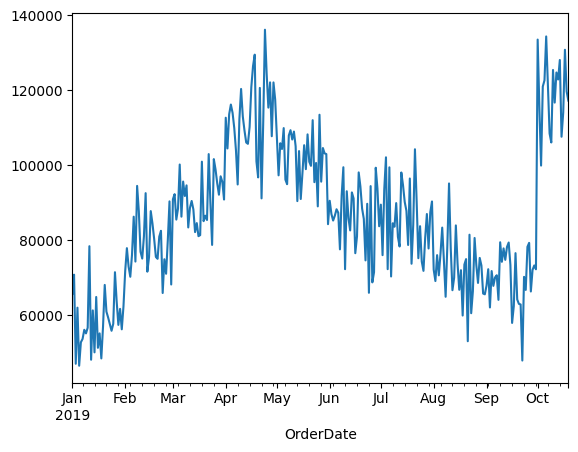

In [32]:
X_train.plot()

In [4]:
initial_df = initial_df.sort_values(by=["OrderDate"], ascending=True)

In [6]:
initial_df["Product"].value_counts()

USB-C Charging Cable          21903
Lightning Charging Cable      21658
AAA Batteries (4-pack)        20641
AA Batteries (4-pack)         20577
Wired Headphones              18882
Apple Airpods Headphones      15549
Bose SoundSport Headphones    13325
27in FHD Monitor               7507
iPhone                         6842
27in 4K Gaming Monitor         6230
34in Ultrawide Monitor         6181
Google Phone                   5525
Flatscreen TV                  4800
Macbook Pro Laptop             4724
ThinkPad Laptop                4128
20in Monitor                   4101
Vareebadd Phone                2065
LG Washing Machine              666
LG Dryer                        646
Name: Product, dtype: int64

<Axes: >

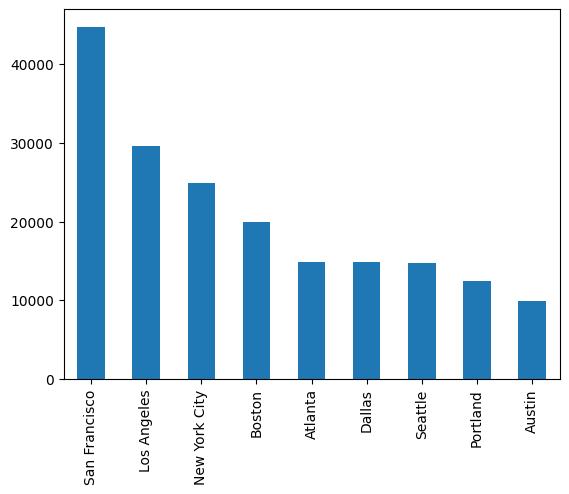

In [12]:
initial_df["CityName"].value_counts().plot(kind="bar")

<Axes: >

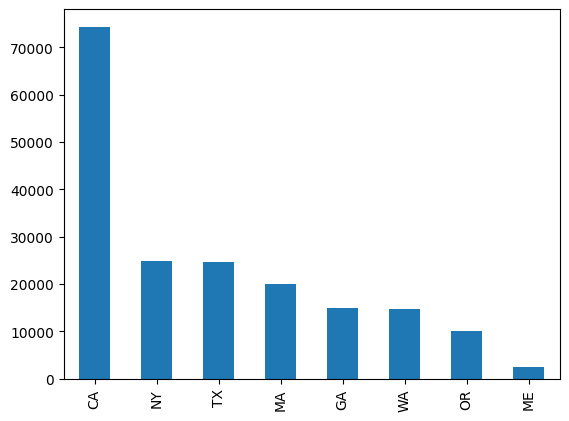

In [13]:
initial_df["StateCode"].value_counts().plot(kind="bar")

<Axes: >

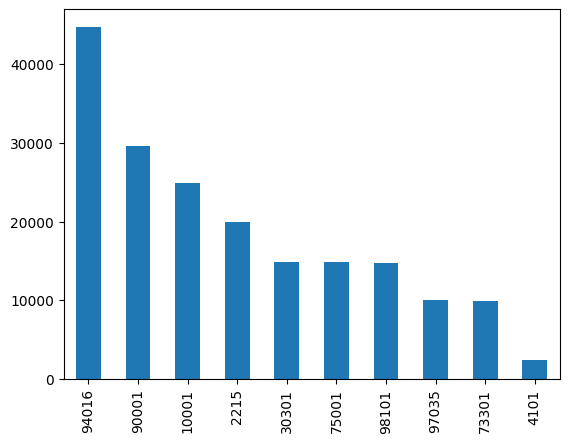

In [3]:
initial_df["ZipCode"].value_counts().plot(kind="bar")

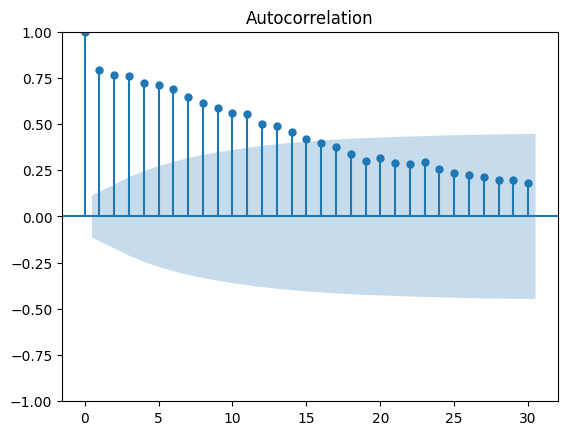

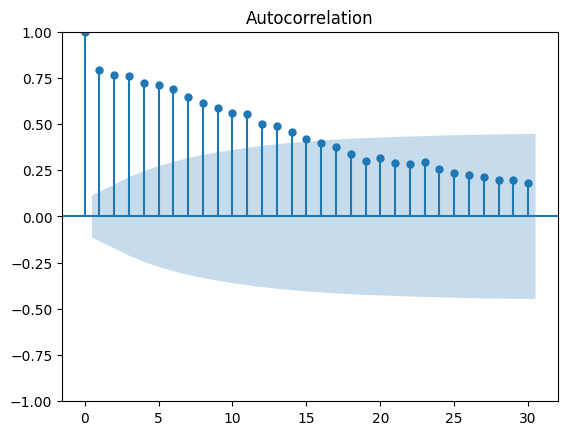

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X_train, lags=30, alpha=0.05)

- We have some autocorrelation.
- A decreasing trend is expected.
- We will look at the seasonality.

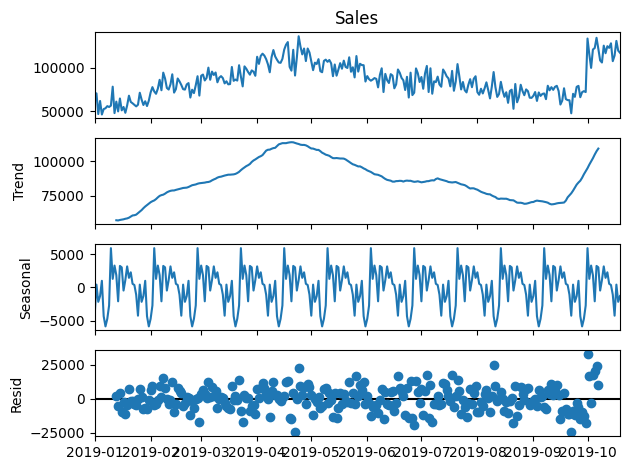

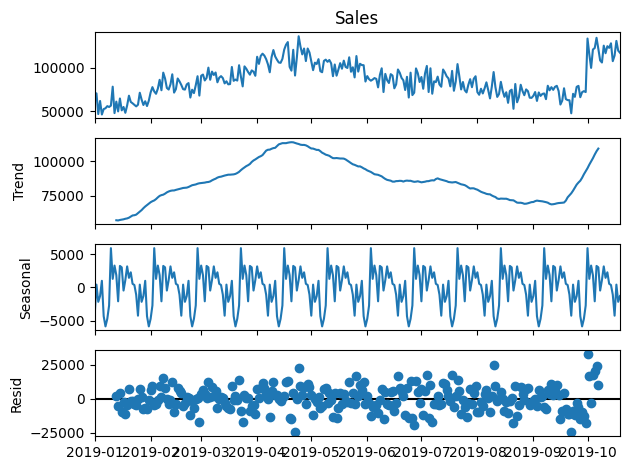

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(X_train, model='additive', period=24)
result.plot()

In [199]:
# fig, ax = plt.subplots(figsize=(10, 6))
# df_by_day.boxplot(by="Hour", column="Sales", ax=ax)
# df_by_day.groupby('Hour')['Sales'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Sales')
# ax.set_title('Sales distribution by day')
# fig.suptitle('')
# plt.show();

In [200]:
# fig, ax = plt.subplots(figsize=(10, 6))
# df_by_day.boxplot(by="Month", column="Sales", ax=ax)
# df_by_day.groupby('Month')['Sales'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Sales')
# ax.set_title('Sales distribution by day')
# fig.suptitle('')
# plt.show();

In [40]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [52]:
# step 1: data specification

# step 2: specifying forecasting horizon
fh = ForecastingHorizon(X_val.index, is_relative=False)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(X_train)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

(array([-40.,   0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.]),
 [Text(-40.0, 0, ''),
  Text(0.0, 0, '2019-01-01 00:00:00'),
  Text(40.0, 0, '2019-02-10 00:00:00'),
  Text(80.0, 0, '2019-03-22 00:00:00'),
  Text(120.0, 0, '2019-05-01 00:00:00'),
  Text(160.0, 0, '2019-06-10 00:00:00'),
  Text(200.0, 0, '2019-07-20 00:00:00'),
  Text(240.0, 0, '2019-08-29 00:00:00'),
  Text(280.0, 0, '2019-10-08 00:00:00'),
  Text(320.0, 0, '2019-11-17 00:00:00'),
  Text(360.0, 0, '')])

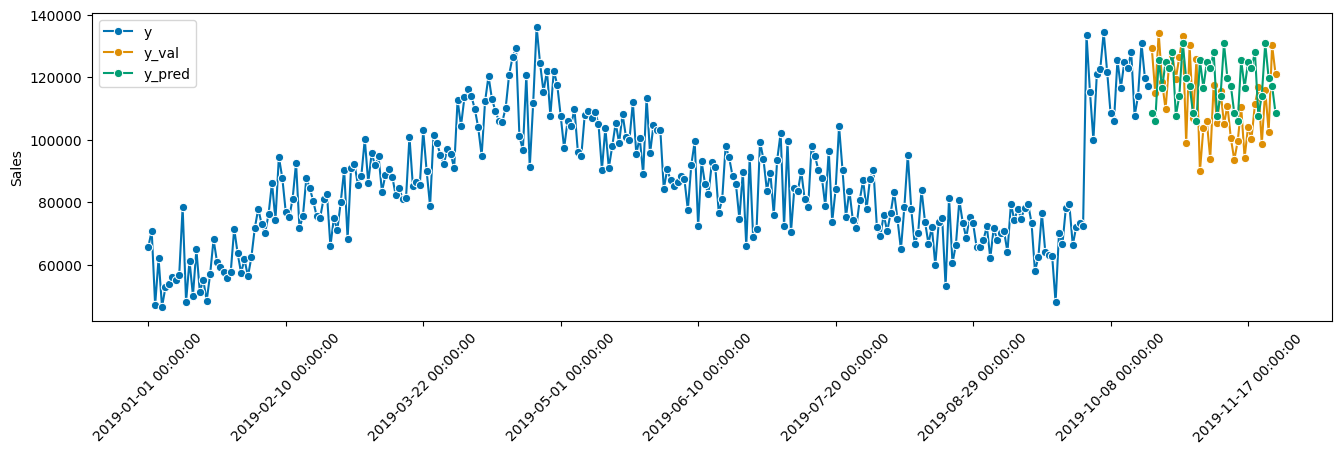

In [53]:
# optional: plotting predictions and past data
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
plot_series(X_train,X_val, y_pred, labels=["y","y_val", "y_pred"])
plt.xticks(rotation=45)

In [54]:
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import BaggingForecaster
forecaster = BaggingForecaster(
    STLBootstrapTransformer(sp=12), NaiveForecaster(sp=12)
)

In [55]:
forecaster.fit(y=X_train, fh=fh)

BaggingForecaster(bootstrap_transformer=STLBootstrapTransformer(),
                  forecaster=NaiveForecaster(sp=12))

In [56]:
y_pred = forecaster.predict(fh=fh)  

(array([-40.,   0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.]),
 [Text(-40.0, 0, ''),
  Text(0.0, 0, '2019-01-01 00:00:00'),
  Text(40.0, 0, '2019-02-10 00:00:00'),
  Text(80.0, 0, '2019-03-22 00:00:00'),
  Text(120.0, 0, '2019-05-01 00:00:00'),
  Text(160.0, 0, '2019-06-10 00:00:00'),
  Text(200.0, 0, '2019-07-20 00:00:00'),
  Text(240.0, 0, '2019-08-29 00:00:00'),
  Text(280.0, 0, '2019-10-08 00:00:00'),
  Text(320.0, 0, '2019-11-17 00:00:00'),
  Text(360.0, 0, '')])

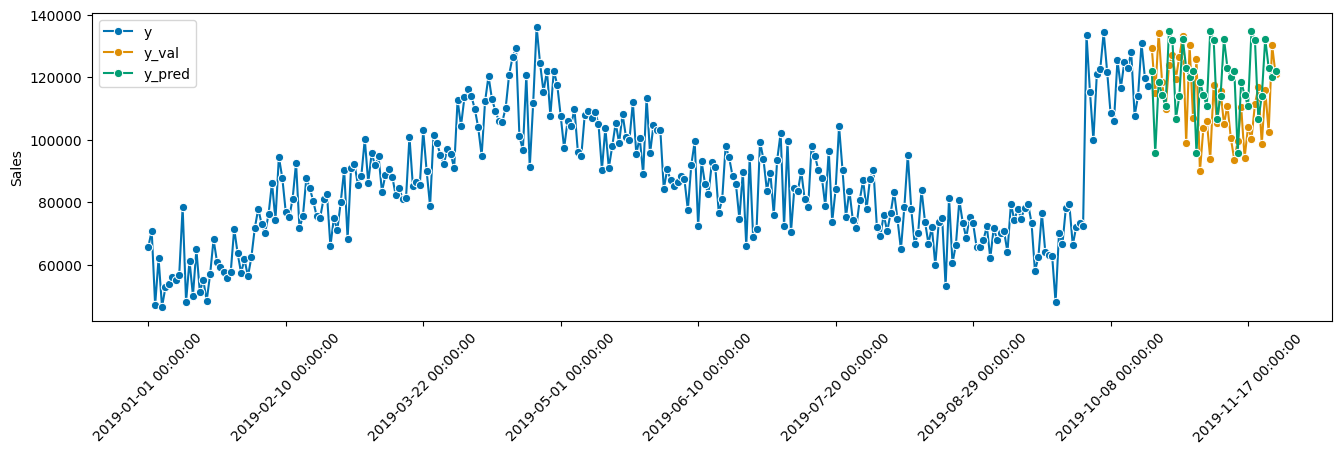

In [57]:
from sktime.utils.plotting import plot_series
plot_series(X_train,X_val, y_pred, labels=["y","y_val", "y_pred"])
plt.xticks(rotation=45)

In [61]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error
print("MAE:", mean_absolute_error(X_val, y_pred, squared=False))
print("MAPE:", mean_absolute_percentage_error(X_val, y_pred))

MAE: 14234.982957627659
MAPE: 0.13353986692311853


In [64]:
y_test_pred = forecaster.predict(fh=ForecastingHorizon(X_test.index, is_relative=False))  

(array([-4.,  0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 [Text(-4.0, 0, ''),
  Text(0.0, 0, '2019-11-26 00:00:00'),
  Text(4.0, 0, '2019-11-30 00:00:00'),
  Text(8.0, 0, '2019-12-04 00:00:00'),
  Text(12.0, 0, '2019-12-08 00:00:00'),
  Text(16.0, 0, '2019-12-12 00:00:00'),
  Text(20.0, 0, '2019-12-16 00:00:00'),
  Text(24.0, 0, '2019-12-20 00:00:00'),
  Text(28.0, 0, '2019-12-24 00:00:00'),
  Text(32.0, 0, '2019-12-28 00:00:00'),
  Text(36.0, 0, '2020-01-01 00:00:00'),
  Text(40.0, 0, '')])

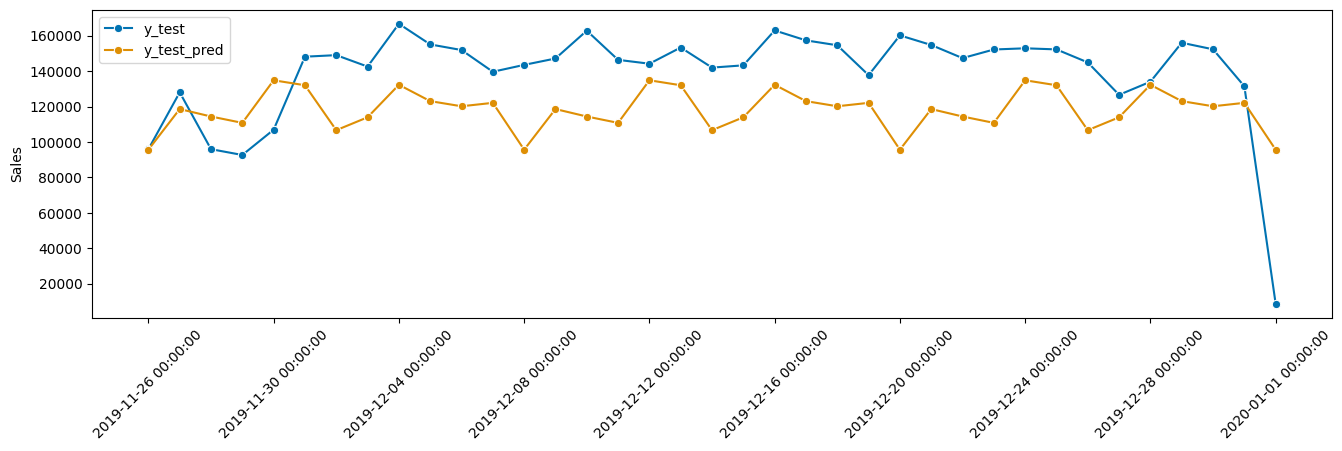

In [65]:
plot_series(X_test, y_test_pred, labels=["y_test", "y_test_pred"])
plt.xticks(rotation=45)